In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys,time,os
from scipy.integrate import simps

from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm,skew,kurtosis,cauchy,chi2

from sklearn.decomposition import FastICA
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture as GMM
from sklearn.neighbors import KernelDensity as KD

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import matplotlib as mpl
label_size = 15
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

sys.path.append('/n/home04/adiazrivero/likelihood_nongaussianity/ffjord/')
from functions import *


rootdir = '/n/home04/adiazrivero/likelihood_nongaussianity/MultiDark_powerspectra/'
sys.path.insert(1, rootdir + 'chang_code/nonGaussLike/nongausslike/')
import knn as kNN
import pyflann
from skl_groups.divergences import KNNDivergenceEstimator
from skl_groups.features import Features

/n/home04/adiazrivero/.conda/envs/rnvp/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/n/home04/adiazrivero/.conda/envs/rnvp/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:

def kNNdiv_general(X, Y, Knn=3, div_func='kl',alpha=None, njobs=1,): #renyi:.5
    """
    kNN divergence estimate for samples drawn from any two arbitrary distributions.
    """
    if Y.shape[1] != X.shape[1]:
        raise ValueError('dimension between X_white and Gaussian reference distribution do not match') 
        
    if isinstance(Knn, int): 
        Knns = [Knn]
    elif isinstance(Knn, list): 
        Knns = Knn    
    
    if alpha is not None:
        div_func = div_func +':%s' % alpha
    
    kNN = KNNDivergenceEstimator(div_funcs=[div_func], Ks=Knns, version='slow', clamp=False, n_jobs=njobs)
    feat = Features([X, Y])
    div_knn = kNN.fit_transform(feat)
    
    if len(Knns) == 1: 
        return div_knn[0][0][0][1]
    
    div_knns = np.zeros(len(Knns))
    for i in range(len(Knns)): 
        div_knns[i] = div_knn[0][i][0][1]
    return div_knns

def fig_crosses_residual(init,sk,kt,ells=[]):
    
    gauss_sk,gauss_kt = init.compare2Gauss(n_draws=100,plot=False)

    p95_sk = np.percentile(gauss_sk,95,axis=0)
    p68_sk = np.percentile(gauss_sk,68,axis=0)
    p95_kt = np.percentile(gauss_kt,95,axis=0)
    p68_kt = np.percentile(gauss_kt,68,axis=0)

    fig,ax = plt.subplots(1,2,figsize=(20,5),sharey=True)

    ax[0].set_title('Skewness',fontsize=20)
    ax[0].yaxis.grid(which="major", color='gray', linestyle='-', linewidth=1)
    ax[0].xaxis.grid(which="major", color='gray', linestyle='dashed', linewidth=1)

    if len(ells) == 0:
        xs = range(len(sk))
        x_label = 'Bin number'
    else:
        xs = ells
        x_label = '$\ell$'

    ax[0].fill_between(xs,np.zeros(len(p95_sk)),p95_sk,color='gray',alpha=0.5,label='Gauss. 95th perc.')
    ax[0].fill_between(xs,np.zeros(len(p95_sk)),p68_sk,color='gray',alpha=0.7,label='Gauss. 68th perc.')
    ax[0].scatter(xs,sk,color='red',marker='x')        

    ax[0].set_ylabel('|$t$-statistic|',fontsize=20)
    ax[0].set_xlabel(x_label,fontsize=20)
    ax[0].set_xlim(np.amin(xs),np.amax(xs))
    ax[0].tick_params(axis='both', which='major', labelsize=20)

    ax[1].yaxis.grid(which="major", color='gray', linestyle='-', linewidth=1)
    ax[1].xaxis.grid(which="major", color='gray', linestyle='dashed', linewidth=1)
    ax[1].set_title('Kurtosis',fontsize=20)

    ax[1].fill_between(xs,np.zeros(len(p95_kt)),p95_kt,color='gray',alpha=0.5,label='Gauss. 95th perc.')
    ax[1].fill_between(xs,np.zeros(len(p95_kt)),p68_kt,color='gray',alpha=0.7,label='Gauss. 68th perc.')
    ax[1].scatter(xs,kt,color='red',marker='x',label='Data')

    ax[1].tick_params(axis='both', which='major', labelsize=20)
    
    ax[1].set_xlabel(x_label,fontsize=20)
    ax[1].set_xlim(np.amin(xs),np.amax(xs))
    ax[1].legend(fontsize=20,loc='upper right')
                
    plt.subplots_adjust(wspace=0, hspace=0.1)

    plt.show()

class SkewKurtosis:
    
    def __init__(self,data,verbose=False):
        
        self.data = data
        self.num_samples = np.shape(data)[0]
        self.num_bins = np.shape(data)[1]
        
        #since the KDE is done one bin at a time d = 1
        d = 1
        self.scotts_b = self.num_samples**(-1./(d+4))
                
        if verbose == True:
            print('Number of samples: ', self.num_samples,'Number of bins: ',self.num_bins)
        
    def t_stats(self,fit_gauss=False):
        
        listt_sk, listt_kt = [], []

        if fit_gauss == True:
            numrows = int(np.ceil(self.num_bins / 5))
            fig,ax = plt.subplots(numrows,5,figsize=(20,20),sharex=True,sharey=True)
        
        count1 = 0
        count2 = 0
        tot = 0
                
        for i in range(self.num_bins):

            data_bin = self.data[:,i]  
            sk = skew(data_bin)
            se_sk = np.sqrt(variance_skewness(self.num_samples))
            t_sk = sk/se_sk
            listt_sk.append(np.abs(t_sk))

            kt = kurtosis(data_bin)
            se_kt = np.sqrt(variance_kurtosis(self.num_samples))
            t_kt = kt/se_kt
            listt_kt.append(np.abs(t_kt))

            if fit_gauss == True:

                data_bin = data_bin.reshape(-1,1)

                n, bins, patches = ax[count1,count2].hist(data_bin,bins=np.linspace(np.amin(data_bin),np.amax(data_bin),50),density=True,label='skew = %.2f  kurt = %.2f' % (sk,kt),color='lightblue')

                kde = KernelDensity(kernel='gaussian', bandwidth=self.scotts_b).fit(data_bin)
                xs = np.linspace(np.amin(data_bin),np.amax(data_bin),50).reshape(-1, 1)
                log_dens = kde.score_samples(xs)
                ax[count1,count2].plot(xs[:,0], np.exp(log_dens),label='KDE',color='k',linewidth=2)
                
                (mu, sigma) = norm.fit(data_bin)
                y = norm.pdf(bins, mu, sigma)
                ax[count1,count2].plot(bins, y, 'r--', linewidth=2,label='Fit N(%.1f,%.1f)' % (mu,sigma))
                #ax[count1,count2].set_title('Bin %s' % i, fontsize=15)
                
                #BOSS
                ax[count1,count2].text(-4,0.45,'Bin %s' % i,fontsize=15)
                ax[count1,count2].text(1,0.4,'$t_{\\rm skew}$ = %.2f' % (t_sk),fontsize=15)
                ax[count1,count2].text(1,0.3,'$t_{\\rm kurt}$ = %.2f' % (t_kt),fontsize=15)
                #WL
                #ax[count1,count2].text(-4,0.45,'Bin %s' % i,fontsize=15)
                #ax[count1,count2].text(1.75,0.4,'$t_{\\rm skew}$ = %.2f' % (t_sk),fontsize=15)
                #ax[count1,count2].text(1.75,0.3,'$t_{\\rm kurt}$ = %.2f' % (t_kt),fontsize=15)
                
                count2 += 1
                if count2 == 5:
                    count1 += 1
                    count2 = 0   
                tot += 1
        
        if fit_gauss == True:
            custom_lines = [Line2D([0], [0], color='lightblue', lw=4),
                            Line2D([0], [0], color='red',linestyle='dashed'),
                            Line2D([0], [0], color='k',)]

            ax[count1,count2].legend(custom_lines, ['Data', 'Gaussian Fit', 'KDE'],fontsize=15)
            ax[count1,count2].get_xaxis().set_visible(False)
            ax[count1,count2].get_yaxis().set_visible(False)

            while count2 < 4:
                count2 += 1
                fig.delaxes(ax[count1,count2])
            plt.subplots_adjust(wspace=0, hspace=0)
            plt.show()
        
        self.arr_sk = np.array(listt_sk)
        self.arr_kt = np.array(listt_kt)
        
        return self.arr_sk,self.arr_kt
    
    def union_intersection(self,verbose=False):
        
        twosig_sk = self.arr_sk[self.arr_sk > 2]
        twosig_sk_ind = np.array(range(len(self.arr_sk)))[self.arr_sk > 2]
        twosig_kt = self.arr_kt[self.arr_kt > 2]
        twosig_kt_ind = np.array(range(len(self.arr_kt)))[self.arr_kt > 2]

        union = len(set(twosig_sk_ind) | set(twosig_kt_ind))
        intersection = len(set(twosig_sk_ind) & set(twosig_kt_ind))

        if verbose == True:
            print('Total number of elements that have at least one measure > 2 sigma : ', union)
            print('Total number of elements that have both measures > 2 sigma : ', intersection)
        
        return union,intersection
    
    def figures(self):

        fig, ax = plt.subplots(figsize=(8,5))
        fig.suptitle('Nongaussianity of individual bins (%s samples)' % self.num_samples,fontsize=20)
        ax.yaxis.grid(which="major", color='gray', linestyle='-', linewidth=1)
        ml = MultipleLocator()
        ax.xaxis.set_minor_locator(ml)
        ax.xaxis.grid(which="both", color='gray', linestyle='dashed', linewidth=0.7, alpha=0.5)
        ax.scatter(range(len(self.arr_sk)),self.arr_sk,marker='x',label='$t_{skew}$')
        ax.scatter(range(len(self.arr_kt)),self.arr_kt,marker='v',label='$t_{kurt}$')
        ax.legend(loc='upper right',fontsize=20)
        ax.set_xlabel('Bin number',fontsize=20)
        ax.set_ylabel('$\mid$ $t$-statistic $\mid$',fontsize=20)
        plt.show()
        
    def compare2Gauss(self,n_draws=1000,plot=False):

        mu = np.mean(self.data,axis=0)
        cov = np.cov(self.data.T)

        all_sk, all_kt = [], []
        all_union, all_inter = [], []

        for _ in range(n_draws):

            samps = mvn.rvs(mu,cov,self.num_samples)
            init = SkewKurtosis(samps,verbose=False)
            arr_sk2, arr_kt2 = init.t_stats()
            uni2,inter2 = init.union_intersection(verbose=False)
            all_sk.append(arr_sk2), all_kt.append(arr_kt2)
            all_union.append(uni2), all_inter.append(inter2) 

        all_sk, all_kt = np.array(all_sk), np.array(all_kt)
        
        if plot: 
            fig,ax = plt.subplots(7,5,figsize=(20,20))
            count1 = 0
            count2 = 0
            for i in range(self.num_bins):
                ax[count1,count2].axvline(self.arr_sk[i],label='True $t_{\\rm skew}$',color='k')
                ax[count1,count2].axvline(self.arr_kt[i],label='True $t_{\\rm kurt}$',color='k',linestyle='dotted')
                ax[count1,count2].hist(all_sk[:,i],bins=np.linspace(0,4,25),label='Bin %s $t_{\\rm skew}$' % i,color='b')
                ax[count1,count2].hist(all_kt[:,i],alpha=0.8,bins=np.linspace(0,4,25),label='Bin %s $t_{\\rm kurt}$' % i,color='orange')

                ax[count1,count2].axvline(np.mean(all_sk[:,i],axis=0),label='mean',color='red')
                ax[count1,count2].axvline(np.median(all_kt[:,i],axis=0),label='median',color='red',linestyle='dotted')
                ax[count1,count2].axvline(np.percentile(all_kt[:,i],95,axis=0),label='95th perc.',color='red',linestyle='dashed')

                ax[count1,count2].set_xlim(0,6)
                ax[count1,count2].grid()
                count2 += 1
                if count2 == 5:
                    count1 += 1
                    count2 = 0       
            ax[0,0].legend(fontsize=10)
                    
            plt.show()

        return all_sk,all_kt

class PairwiseCovariance:
    
    def __init__(self,data):
        
        self.data = data
        self.num_samples = np.shape(data)[0]
        self.num_bins = np.shape(data)[1]
        
        d = 1
        self.scotts_b = self.num_samples**(-1./(d+4))  
        
    def transcovariance(self, Splus=False, Sdiv=False, Smult=False, n_bins=50, plot=False, example=False):
            
        X_meansub = self.data - np.mean(self.data,axis=0)
        
        mat_hist = np.zeros((self.num_bins,self.num_bins))
        mat_kde = np.zeros((self.num_bins,self.num_bins))
        rng = range(self.num_bins)

        for i in rng: 

            for j in range(i,rng[-1]+1):

                if i == j:
                    continue

                cols = X_meansub[:,[i,j]]
                X_w, W = whiten(cols)
                
                if Splus == True:
                    metric = np.sum(X_w,axis=1)
                    
                elif Sdiv == True:
                    metric = np.array([row[0] / row[1] for row in X_w])

                elif Smult == True:
                    metric = np.array([row[0] * row[1] for row in X_w])                 
                    
                metric = metric.reshape(-1,1)

                xs0_hist = np.linspace(np.amin(metric),np.amax(metric),n_bins+1)
                
                xs0 = np.linspace(np.amin(metric),np.amax(metric),n_bins)
                dx = xs0[1] - xs0[0]
                xs = xs0.reshape(-1, 1)
                
                if Splus == True:
                    label = 'Norm'
                    func = norm
                    
                    theory1 = func.pdf(xs0,0,np.sqrt(2))
                    hist2, bins, patches = plt.hist(metric, density=True, bins=xs0_hist)
                    xs2 = rebin(bins)       
                    theory2 = func.pdf(xs2,0,np.sqrt(2))
                    
                elif Sdiv == True:
                    label = 'Cauchy'
                    func = cauchy
                    
                    theory1 = func.pdf(xs0)
                    hist2, bins, patches = plt.hist(metric, density=True, bins=xs0_hist)
                    xs2 = rebin(bins)       
                    theory2 = func.pdf(xs2)
                    
                elif Smult == True:
                    label = 'VarGamma'
                    func = VarGamma
                    
                    theory1 = np.array(func.pdf(xs0,sigma=1/2))   
                    hist2, bins, patches = plt.hist(metric, density=True, bins=xs0_hist)
                    xs2 = rebin(bins)       
                    theory2 = np.array(func.pdf(xs2,sigma=1/2))
                    #area_vg = simps(theory.reshape(-1), dx=dx)
                    #area_kde = simps(np.exp(H), dx=dx)
                    #print(area_vg,area_kde) 
                    
                #using KDE
                kde = KernelDensity(kernel='gaussian', bandwidth=self.scotts_b).fit(metric)
                H = kde.score_samples(xs)
                hist1 = np.exp(H)

                diff1 = 1/(len(xs)) * np.sum((hist1 - theory1)**2)
                mat_kde[i][j] = diff1 
                mat_kde[j][i] = diff1
                
                #using histogram
                diff2 = 1/(len(xs2)) * np.sum((hist2 - theory2)**2)
                mat_hist[i][j] = diff2
                mat_hist[j][i] = diff2
                
                if plot == True:
                    
                    print('diff KDE (%s bins): %.5f' % (len(hist1),diff1), 'diff hist (%s bins): %.5f' % (len(hist2),diff2))
                    
                    plt.plot(xs[:,0], hist1, label='KDE')
                    plt.plot(xs, theory1, 'r--', linewidth=2,label='theory')
                    plt.plot(xs2, theory2, 'g', linewidth=2,label='theory2')
                    plt.title('%s %s' % (i,j))
                    plt.legend()
                    plt.show()  
 
                    if example:
                        sys.exit()
            
                else:
                    plt.close()
                    
        return mat_kde,mat_hist    
    
def ICA_loglikes_samples(arr):

    N_samp = np.shape(arr)[0]
    N_bins = np.shape(arr)[1]

    d = 1
    scotts_b = N_samp**(-1./(d+4))
    print('scotts_b = %.2f' % scotts_b)

    ica = FastICA(whiten=False,max_iter=1000,tol=1e-3)
    S_ = ica.fit_transform(arr)
    A_ = ica.mixing_
    #W_ica = ica.components_
    
    X_ref_ica_unmixed = np.zeros((N_samp,N_bins))
    X_ref_ica = np.zeros((N_samp,N_bins))

    loglike_ica = np.zeros(np.shape(X_w)[0])

    for j in range(N_bins):

        X_ica_ind = S_[:,j].reshape(-1, 1)
        kde = KernelDensity(bandwidth=scotts_b,kernel='gaussian').fit(X_ica_ind)

        samps = kde.sample(N_samp) #samples for the jth bin
        X_ref_ica_unmixed[:,j] = np.ndarray.flatten(samps)

        log_dens = kde.score_samples(X_ica_ind)#.reshape(len(X_ica_ind),1))
        loglike_ica += log_dens

    X_ref_ica = np.dot(X_ref_ica_unmixed,A_.T) #should be akin to samples X^mock.
    
    return loglike_ica, X_ref_ica
    
def GMM_loglikes_samples(arr,N_comp=None):
    
    if N_comp == None:
        N_comp = np.shape(arr)[1]   
        
    N_samp = np.shape(arr)[0]
    gmm = GMM(n_components=N_comp, covariance_type='full', init_params='kmeans')
    gmm.fit(arr)
    X_ref_gmm, cs = gmm.sample(N_samp)
    loglike_gmm = gmm.score_samples(arr)
    
    return loglike_gmm, X_ref_gmm
  
def NF_loglikes_samples(arr,load_dir,epoch,dim,restart=False):
    
    model, sample_fn, density_fn = restart_ffjord(load_dir,epoch=epoch,dim=dim,restart=restart)
    
    with torch.no_grad():

        arr = arr.type(torch.float32).to(device)
        zero = torch.zeros(arr.shape[0], 1).to(arr)
        z, delta_logp = model(arr, zero)
        logpz = standard_normal_logprob(z).sum(1, keepdim=True)
        logpx = logpz - delta_logp
    
    loglike_nf = logpx.cpu().numpy()

    X_ref_nf = flow_samples(np.shape(arr)[0], np.shape(arr)[1], prior_sample=torch.randn, transform=sample_fn).astype(np.float64)
    
    return loglike_nf, X_ref_nf, sample_fn



def NF_loglikes_samples(arr,load_dir,epoch,dim,restart=False):
    
    model, sample_fn, density_fn = restart_ffjord(load_dir,epoch=epoch,dim=dim,restart=restart)
    
    with torch.no_grad():

        arr = arr.type(torch.float32).to(device)
        zero = torch.zeros(arr.shape[0], 1).to(arr)
        z, delta_logp = model(arr, zero)
        logpz = standard_normal_logprob(z).sum(1, keepdim=True)
        logpx = logpz - delta_logp
    
    loglike_nf = logpx.cpu().numpy()

    X_ref_nf = flow_samples(np.shape(arr)[0], np.shape(arr)[1], prior_sample=torch.randn, transform=sample_fn).astype(np.float64)
    
    return loglike_nf, X_ref_nf, sample_fn

def load_NFsamples(data_type,epoch):
    
    X_samp = np.load('/n/home04/adiazrivero/likelihood_nongaussianity/ffjord/TEST_NFSAMPLES/nfsamples_%s_epoch_%s.npy' % (data_type,epoch))
    
    return X_samp

def npd_function_nf(X, n_sample=50, k=10, s=2000, n_comp=10, sample_function=None, verbose=False):

    X_ref = flow_samples(s, np.shape(X)[1], prior_sample=torch.randn, transform=sample_fn).astype(np.float64)

    kl_ref, kl_data = [], []

    for i in range(n_sample):
        
        if verbose:
            print(i)
        
        Y_ref = flow_samples(s-1, np.shape(X)[1], prior_sample=torch.randn, transform=sample_fn).astype(np.float64)

        kl_ref.append(kNNdiv_general(X_ref, Y_ref, Knn=k, alpha=None, div_func='kl'))
        kl_data.append(kNNdiv_general(X, Y_ref, Knn=k, alpha=None, div_func='kl'))    
        
    return kl_ref, kl_data

In [145]:
data_type = 'WL'
lmax = 5000

X_pk, _, _, ells = load_WL(ell_min=100,ell_max=lmax,return_ells=True)

print('Using only 2048 mocks')
inds = np.random.choice(len(X_pk),2048)
X_pk = X_pk[inds]
#X_pk = X_pk[:2048]
X_res = X_pk - np.mean(X_pk,axis=0)
X_w, W = whiten(X_res)

34 dimensional data with 76487 samples
Using only 2048 mocks


#### Figure 1

In [ ]:
def nonparamdiv_function(X, n_sample=50, k=10, s=2000, verbose=False):
    """
    X : 2D numpy array whose likelihood we want to compare to a Gaussian likelihood
    n_sample: number of independent Gaussian realizations of the data to draw
    k : number of nearest-neighbors
    s : number of samples to draw from the Gaussian 
    """
    C_x = np.cov(X.T)
    mu = np.mean(X,axis=0) #np.zeros(dim)

    X_ref_gauss = mvn.rvs(mu, C_x, size=s)

    kl_ref, kl_data = [], []

    for i in range(n_sample):
        
        if verbose:
            print(i)

        Y_ref_gauss = mvn.rvs(mu, C_x, size=s-1)
        
        kl_ref.append(kNNdiv_general(X_ref_gauss, Y_ref_gauss, Knn=k, alpha=None, div_func='kl'))
        kl_data.append(kNNdiv_general(X, Y_ref_gauss, Knn=k, alpha=None, div_func='kl'))
        
    return kl_ref, kl_data

def figure_kldiv(kl_ref,kl_data,figsize=(6,6)):
    
    fig,ax = plt.subplots(1,figsize=figsize)

    ax.hist(kl_ref,label='Ref. MVN',color='gray')
    ax.hist(kl_data,label='$D(X^{mock}||Y_{\\rm MVN}^{ref})$',color='red')
    ax.set_xlabel('KL divergence',fontsize=20)
    ax.legend(loc=1,prop={'size': 16})
    ax.tick_params(labelsize=15)
    
    plt.show()

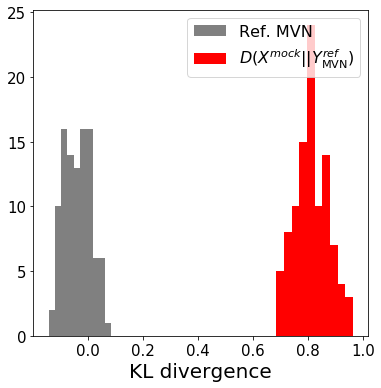

Number of samples:  2048 Number of bins:  34


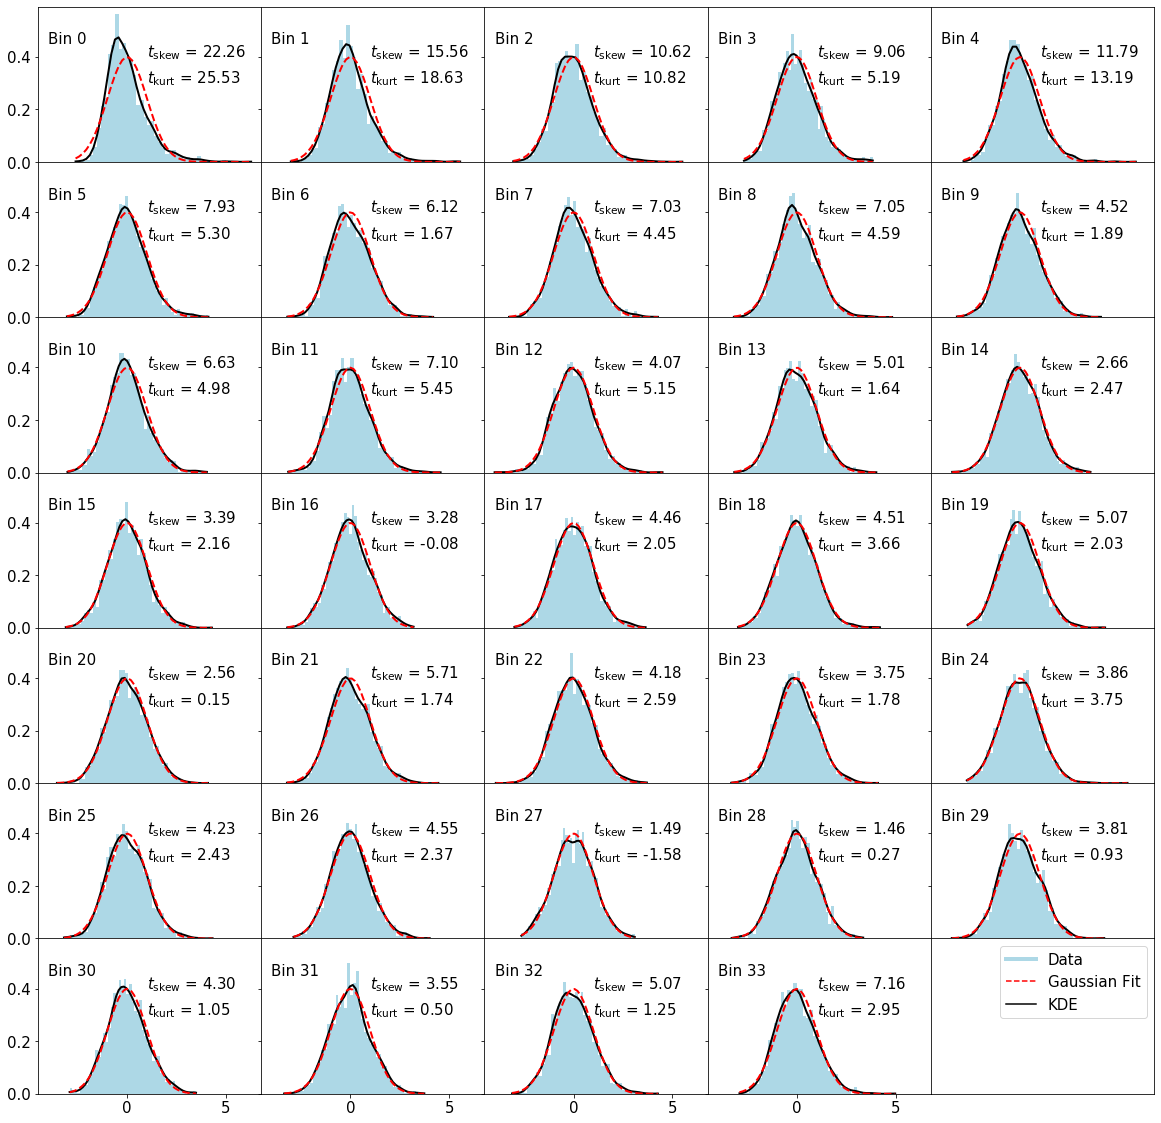

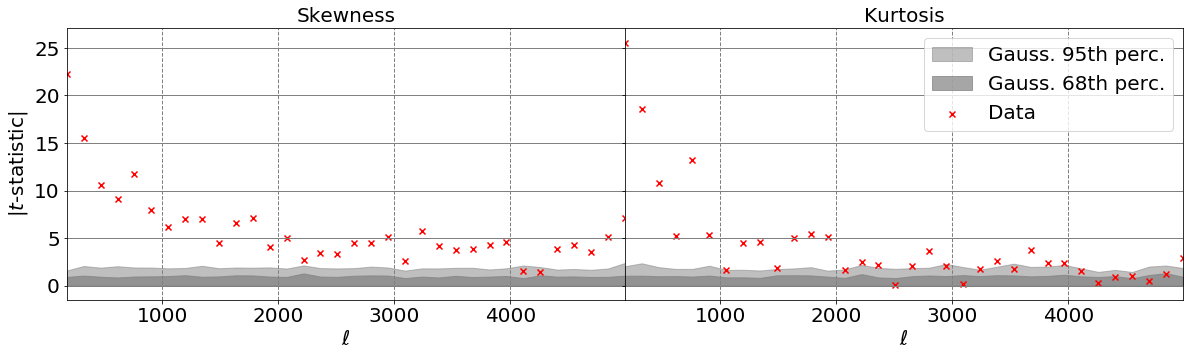

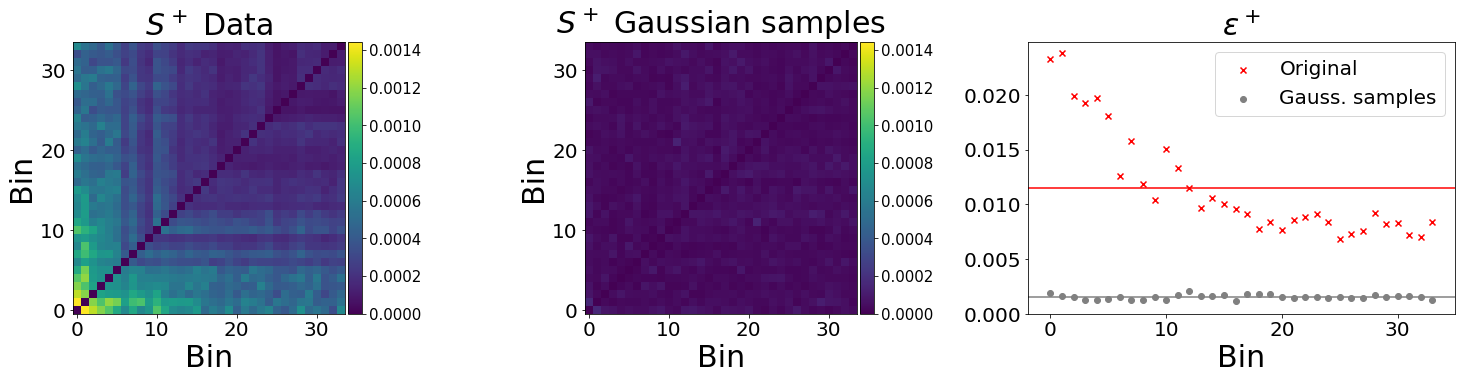

7.49


In [5]:
n = 100
kk = 5
N = len(X_w)
kl_ref1, kl_data1 = nonparamdiv_function(X_w, n_sample=n, k=kk, s=N)

figure_kldiv(kl_ref1, kl_data1, figsize=(6,6))

############

data = X_w

init = SkewKurtosis(data, verbose=True)
arr_sk, arr_kt = init.t_stats(fit_gauss=True)

fig_crosses_residual(init, arr_sk, arr_kt, ells)

#for transcovariance test, need original data
data = X_pk
mu = np.mean(data, axis=0)
C_x = np.cov(data.T)

X_gauss = mvn.rvs(mu, C_x, len(data))

init = PairwiseCovariance(data)
Splus,_ = init.transcovariance(Splus=True,plot=False)

init_gauss = PairwiseCovariance(X_gauss)
Splus_gauss,_ = init_gauss.transcovariance(Splus=True,plot=False)

fig,ax = plt.subplots(1,3,figsize=(26,5))

maxi = np.amax(Splus)
im = ax[0].imshow(Splus,origin='lower',vmin=0,vmax=maxi)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im,cax=cax)
ax[0].set_title('$S^+$ Data',fontsize=30)
ax[0].set_xlabel('Bin',fontsize=30)
ax[0].set_ylabel('Bin',fontsize=30)
ax[0].tick_params(labelsize=20)

im = ax[1].imshow(Splus_gauss,origin='lower',vmin=0,vmax=maxi)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im,cax=cax)
ax[1].set_title('$S^+$ Gaussian samples',fontsize=30)
ax[1].set_xlabel('Bin',fontsize=30)
ax[1].set_ylabel('Bin',fontsize=30)
ax[1].tick_params(labelsize=20)

tot1 = np.sum(Splus,axis=0)
tot1_gauss = np.sum(Splus_gauss,axis=0)
ax[2].set_title('$\\epsilon^+$',fontsize=30)
ax[2].scatter(range(len(Splus)),tot1,marker='x',label='Original',color='red')
ax[2].scatter(range(len(Splus_gauss)),tot1_gauss,label='Gauss. samples',color='gray')
ax[2].axhline(np.mean(tot1),color='red')
ax[2].axhline(np.mean(tot1_gauss),color='gray')
ax[2].set_ylim(0,np.amax(tot1)+1e-3)
ax[2].legend(fontsize=20)
ax[2].set_xlabel('Bin',fontsize=30)
ax[2].tick_params(labelsize=20)

plt.show()

frac1 = (np.mean(tot1)) / np.mean(tot1_gauss)
print('%.2f' % frac1)

#### Figure 2

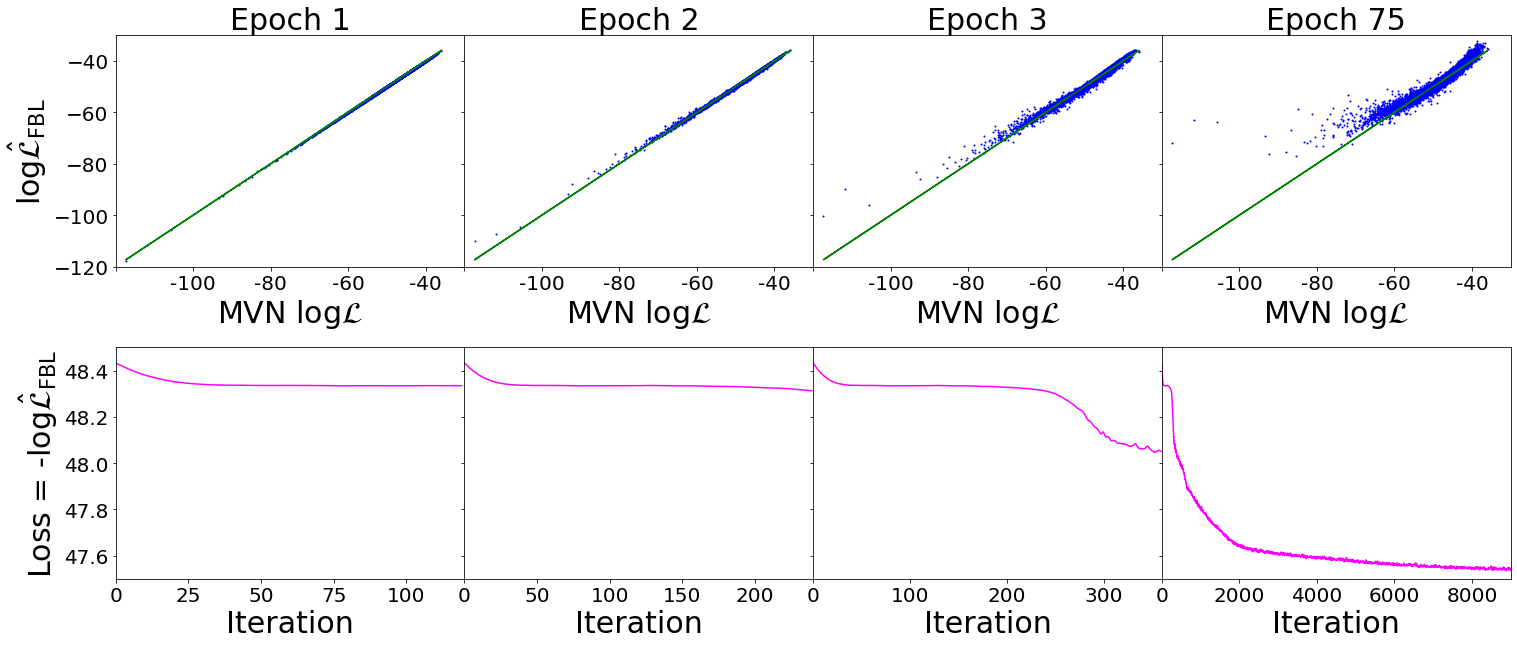

In [6]:
load_dir = '/n/holyscratch01/dvorkin_lab/adiazrivero/ffjord/WLdata_lr0.001_bs500_blocks1_dim64_concatsquash_t0.5_afelu_lmax5000.0_arrays/'

mvn_ll_test = np.load(load_dir + 'mvn_test_loglike.npy')
test_losses = np.load(load_dir + 'test_losses.npy')

fig,ax = plt.subplots(2,4,figsize=(25,10))

ini = 0

for count,epoch in enumerate([1,2,3,75]):
    
    arr = np.load(load_dir + 'epoch%s_predtestloglike.npy' % epoch)
    
    ax[0,count].scatter(mvn_ll_test,arr,s=1,color='blue')
    ax[0,count].plot(mvn_ll_test,mvn_ll_test,color='green')
    ax[0,count].set_xlabel('MVN $\log\mathcal{L}$',fontsize=30)
    ax[0,count].set_xticklabels(['',-100,-80,-60,-40])
    ax[0,count].tick_params(labelsize=20)

    if count == 0:
        ax[0,count].set_ylabel('$\log\hat{\mathcal{L}}_{\\rm FBL}$',fontsize=30)
    if count != 0:
        ax[0,count].set_yticklabels([])
        
    ax[0,count].set_title('Epoch %s' % epoch,fontsize=30)
    ax[0,count].set_ylim(-120,-30)
    ax[0,count].set_xlim(-120,-30)
    
    fin = epoch*120
    losses = test_losses[0:fin]
    ax[1,count].plot(range(len(losses)),losses,color='magenta') 
    ax[1,count].set_xlabel('Iteration',fontsize=30)
    ax[1,count].set_xlim(0,len(losses))
    ax[1,count].set_ylim(47.5,48.5)
    
    if count == 0:
        ax[1,count].set_ylabel('Loss = -$\log\hat{\mathcal{L}}_{\\rm FBL}$',fontsize=30)
    ax[1,count].tick_params(labelsize=20)
        
    if count != 0:
        ax[1,count].set_yticklabels([])
    
plt.subplots_adjust(wspace=0,hspace=0.35)
plt.show()

#### Figure 3

In [3]:
def nonparamdiv_function(X, n_sample=50, k=10, s=2000, verbose=False):
    """
    X : 2D numpy array whose likelihood we want to compare to a Gaussian likelihood
    n_sample: number of independent Gaussian realizations of the data to draw
    k : number of nearest-neighbors
    s : number of samples to draw from the Gaussian 
    """
    C_x = np.cov(X.T)
    mu = np.mean(X,axis=0) #np.zeros(dim)

    X_ref_gauss = mvn.rvs(mu, C_x, size=s)

    kl_ref, kl_data = [], []

    for i in range(n_sample):
        
        if verbose:
            print(i)

        Y_ref_gauss = mvn.rvs(mu, C_x, size=s-1)
        
        kl_ref.append(kNNdiv_general(X_ref_gauss, Y_ref_gauss, Knn=k, alpha=None, div_func='kl'))
        kl_data.append(kNNdiv_general(X, Y_ref_gauss, Knn=k, alpha=None, div_func='kl'))
        
    return kl_ref, kl_data

In [11]:
def npd_function_gmm(X, n_sample=50, k=10, s=2000, n_comp=10, verbose=False):

    gmm = GMM(n_components=n_comp, covariance_type='full',init_params='kmeans')
    gmm.fit(X)
    X_ref,_ = gmm.sample(s)
    
    kl_ref, kl_data = [], []

    for i in range(n_sample):
        
        if verbose:
            print(i)
        
        Y_ref,_ = gmm.sample(s-1)

        kl_ref.append(kNNdiv_general(X_ref, Y_ref, Knn=k, alpha=None, div_func='kl'))
        kl_data.append(kNNdiv_general(X, Y_ref, Knn=k, alpha=None, div_func='kl'))    
        
    return kl_ref, kl_data

In [ ]:
def fig3(kl_ref,kl_data,kl_data2,figsize=(5,5)):
    
    fig,ax = plt.subplots(1,figsize=figsize)

    ax.hist(kl_ref,label='Ref. MVN',color='gray')
    ax.hist(kl_data,label='$D(X^{mock}||Y_{\\rm MVN}^{ref})$',color='red')
    ax.hist(kl_data2,label='$D(X^{mock}||Y_{\\rm DDL}^{ref})$',color='green',alpha=0.5)
    ax.set_title('$P_{\\ell}(k)$',fontsize=20)
    ax.set_xlabel('KL divergence',fontsize=20)
    ax.legend(loc=1,prop={'size': 16})

    plt.show()

In [ ]:
def npd_function_ica(X, n_sample=50, k=10, s=2000, verbose=False):
    
    N_samp = np.shape(X)[0]
    N_bins = np.shape(X)[1]
    
    d = 1
    scotts_b = N_samp**(-1./(d+4))

    ica = FastICA(whiten=False,max_iter=1000,tol=1e-2)
    S_ = ica.fit_transform(X)
    A_ = ica.mixing_

    Y_ref_ica_unmixed = np.zeros((n_sample,N_samp-1,N_bins))
    Y_ref_ica = np.zeros((n_sample,N_samp-1,N_bins))

    for i in range(n_sample): 
        for j in range(N_bins):
            X_ica_ind = S_[:,j].reshape(-1, 1) #shape is now (2048,1)
            kde = KernelDensity(bandwidth=scotts_b,kernel='gaussian').fit(X_ica_ind)
            samps = kde.sample(N_samp-1) #2047 samples for the jth k bin
            Y_ref_ica_unmixed[i,:,j] = np.ndarray.flatten(samps)
        Y_ref_ica[i] = np.dot(Y_ref_ica_unmixed[i],A_.T)#applying the mixing matrix to undo the ICA transformation
    
    X_ref_ica_unmixed = np.zeros((N_samp,N_bins))
    X_ref_ica = np.zeros((N_samp,N_bins))

    for j in range(N_bins):
        X_ica_ind = S_[:,j].reshape(-1, 1) #shape is now (2048,1)
        kde = KernelDensity(bandwidth=scotts_b,kernel='gaussian').fit(X_ica_ind)
        samps = kde.sample(N_samp)#2047 samples for the jth k bin
        X_ref_ica_unmixed[:,j] = np.ndarray.flatten(samps)

    X_ref_ica = np.dot(X_ref_ica_unmixed,A_.T) #applying the mixing matrix to undo the ICA transformation

    kl_ref, kl_data = [], []

    for i in range(n_sample):
        
        if verbose:
            print(i)
        Y_ref_ica_samp = Y_ref_ica[i]
        kl_ref.append(kNNdiv_general(X_ref_ica, Y_ref_ica_samp, Knn=k, alpha=None, div_func='kl'))
        kl_data.append(kNNdiv_general(X, Y_ref_ica_samp, Knn=k, alpha=None, div_func='kl'))   
        
    return kl_ref, kl_data     

scotts_b = 0.22
CONSTRUCTING REGULAR MODEL


/n/home04/adiazrivero/likelihood_nongaussianity/ffjord/lib/layers/odefunc.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).type_as(y)


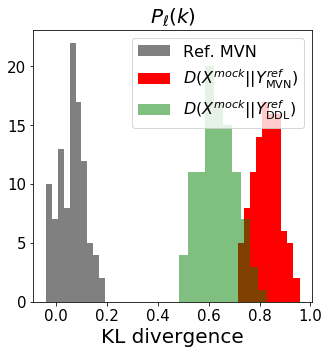

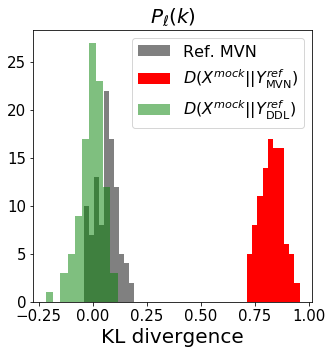

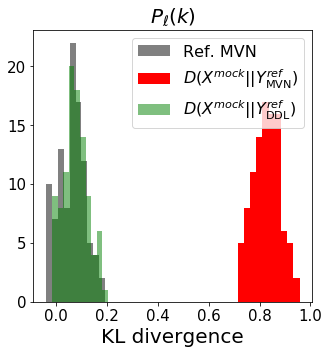

In [134]:
data_type = 'WL'
lmax = 5000

X_pk, _, _, ells = load_WL(ell_min=100, ell_max=lmax, return_ells=True)

print('Using only 2048 mocks')
inds = np.random.choice(len(X_pk), 2048)
X_pk = X_pk[inds]
X_res = X_pk - np.mean(X_pk,axis=0)
X_w, W = whiten(X_res)

n = 100
kk = 10
N = len(X_w)

loglike_mvn = np.log(mvn.pdf(X_w, mean=np.mean(X_w, axis=0), cov=np.cov(X_w.T)))
kl_ref_mvn, kl_data_mvn = nonparamdiv_function(X_w, n_sample=n, k=kk, s=N)

loglike_ica, X_ref_ica = ICA_loglikes_samples(X_w)
kl_ref_ica, kl_data_ica = npd_function_ica(X_w, n_sample=n, k=kk, s=N)

comp = 2
loglike_gmm, X_ref_gmm = GMM_loglikes_samples(X_w, N_comp=comp)
kl_ref_gmm, kl_data_gmm = npd_function_gmm(X_w, n_sample=n, k=kk, s=N, n_comp=comp)

dim = 34
load_dir ='WLdata_lr0.001_bs500_blocks1_dim64_concatsquash_t0.5_afelu_lmax5000.0'
e = 75
loglike_nf, X_ref_nf, sample_fn = NF_loglikes_samples(torch.Tensor(X_w), load_dir, epoch=e, dim=dim, restart=False)
kl_ref_nf, kl_data_nf = npd_function_nf(X_w, n_sample=n, k=kk, s=N, sample_function=sample_fn, verbose=False)

fig3(kl_ref_mvn, kl_data_mvn, kl_data_ica)
fig3(kl_ref_mvn, kl_data_mvn, kl_data_gmm)
fig3(kl_ref_mvn, kl_data_mvn, kl_data_nf)

34 dimensional data with 76487 samples
Using only 2048 mocks
scotts_b = 0.22
CONSTRUCTING REGULAR MODEL


/n/home04/adiazrivero/likelihood_nongaussianity/ffjord/lib/layers/odefunc.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).type_as(y)


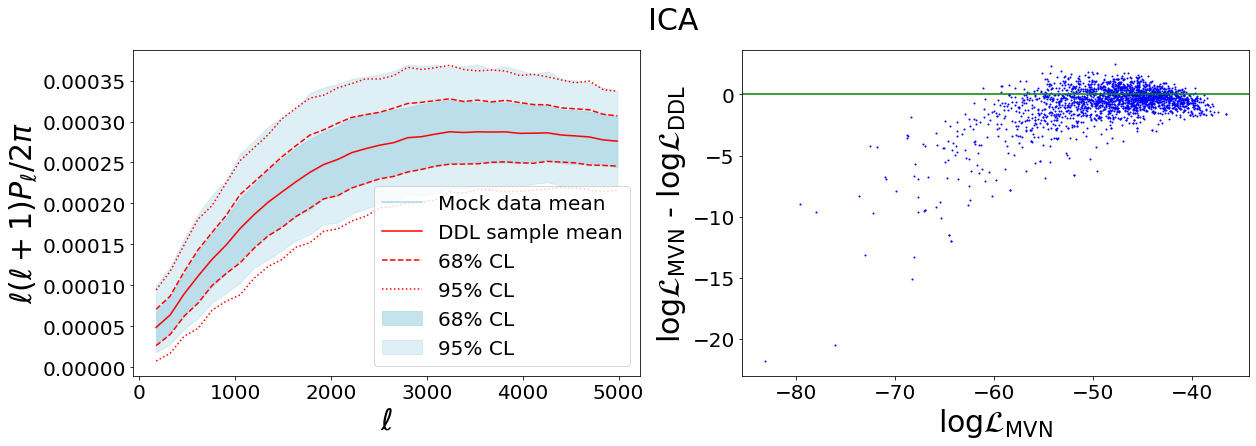

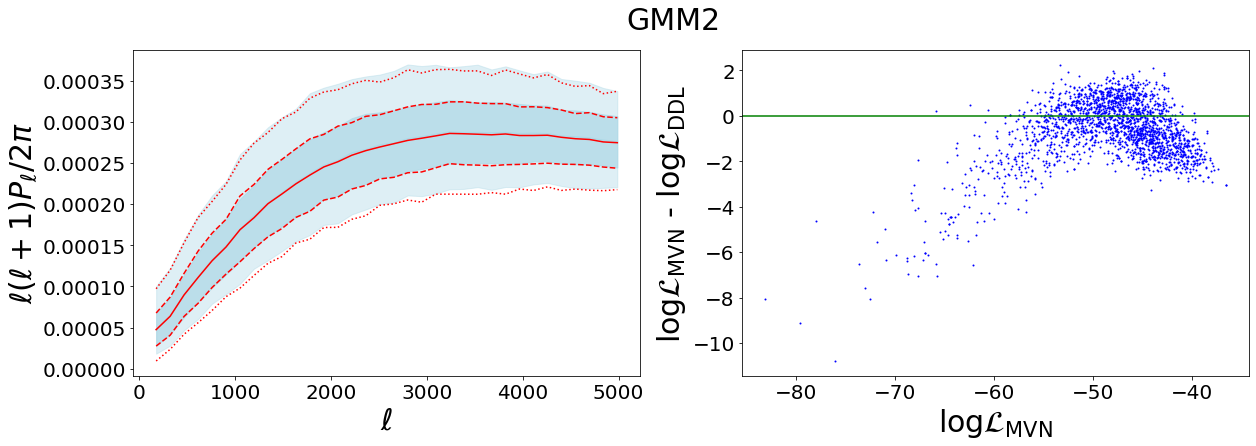

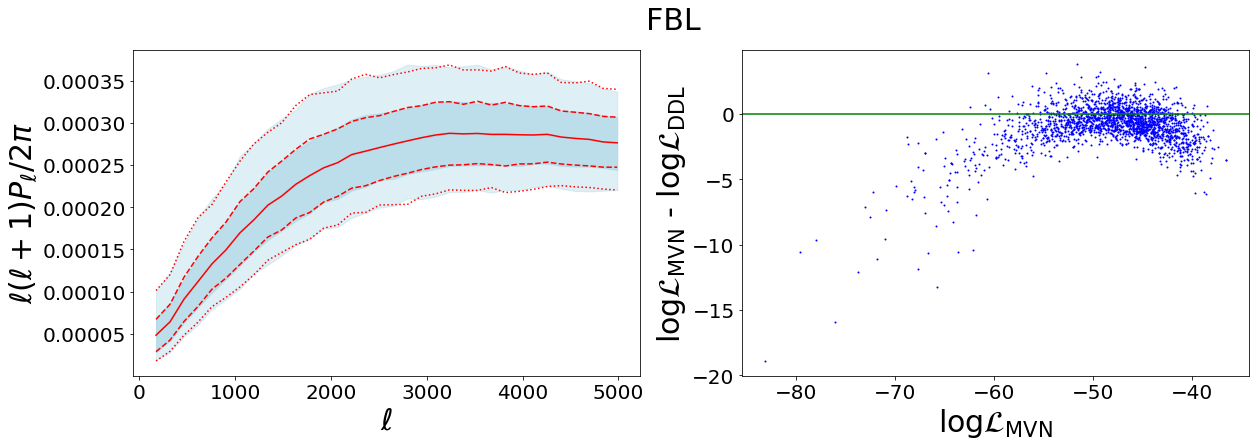

In [141]:
xs = ells

for arr, loglikes, title in zip([X_ref_ica, X_ref_gmm, X_ref_nf],
                              [loglike_ica, loglike_gmm, loglike_nf],
                              ['ICA','GMM2','FBL']):

    if np.shape(loglike_mvn) != np.shape(loglikes):
        loglikes = loglikes.reshape(-1)
    
    fig,ax = plt.subplots(1,2,figsize=(20,6))
    fig.suptitle('%s' % title,fontsize=30)
    
    X_ref = np.dot(arr, np.linalg.inv(W))
    X_ref += np.mean(X_pk,axis=0)

    ax[0].plot(xs,np.mean(X_pk,axis=0),color='lightblue',label='Mock data mean')
    ax[0].fill_between(xs,np.percentile(X_pk,16,axis=0),np.percentile(X_pk,84,axis=0),alpha=0.7,color='lightblue',label='68% CL')
    ax[0].fill_between(xs,np.percentile(X_pk,2.5,axis=0),np.percentile(X_pk,97.5,axis=0),alpha=0.4,color='lightblue',label='95% CL')

    ax[0].plot(xs,np.mean(X_ref,axis=0),color='r',label='DDL sample mean')
    ax[0].plot(xs,np.percentile(X_ref,16,axis=0),color='r',linestyle='dashed',label='68% CL')
    ax[0].plot(xs,np.percentile(X_ref,84,axis=0),color='r',linestyle='dashed')
    ax[0].plot(xs,np.percentile(X_ref,2.5,axis=0),color='r',linestyle='dotted')
    ax[0].plot(xs,np.percentile(X_ref,97.5,axis=0),color='r',linestyle='dotted',label='95% CL')    
    ax[0].set_xlabel('$\ell$',fontsize=30)
    ax[0].set_ylabel('$\ell(\ell+1) P_{\ell}/2\pi$',fontsize=30)
    
    ax[1].scatter(loglike_mvn,loglike_mvn - loglikes,s=1,color='blue')
    ax[1].axhline(0,color='green')
    ax[1].set_xlabel('log$\mathcal{L}_{\\rm MVN}$',fontsize=30)
    ax[1].set_ylabel('log$\mathcal{L}_{\\rm MVN}$ - log$\mathcal{L}_{\\rm DDL}$',fontsize=30)
    
    if title =='ICA':
        ax[0].legend(fontsize=20)
    
    for c in range(2):
        ax[c].tick_params(labelsize=20)

    plt.show()


#### Figure 4

In [138]:
def fig_dataintervals_lmax(data_type,likelihood,kl_ddl,kl_ref,NF_label=None,lmax=5000.0,epoch=None):

    eps_gauss = np.load('%s_MVN_lmax5000.0_epss.npy' % (data_type))
    sks_gauss = np.load('%s_MVN_lmax5000.0_sks.npy' % (data_type))
    kts_gauss = np.load('%s_MVN_lmax5000.0_kts.npy' % (data_type))

    data_epss = np.load('%s_full_lmax%s_epss.npy' % (data_type,lmax))
    data_sks = np.load('%s_full_lmax%s_sks.npy' % (data_type,lmax))
    data_kts = np.load('%s_full_lmax%s_kts.npy' % (data_type,lmax))

    if likelihood == 'NF':
        
        if NF_label != None:

            samp_epss = np.load('%s_%s_lmax%s_epss_%s_epoch5000.0.npy' % (data_type,likelihood,NF_label,epoch))
            samp_sks = np.load('%s_%s_lmax%s_sks_%s_epoch5000.0.npy' % (data_type,likelihood,NF_label,epoch))
            samp_kts = np.load('%s_%s_lmax%s_kts_%s_epoch5000.0.npy' % (data_type,likelihood,NF_label,epoch))

    else: 
        
        samp_epss = np.load('%s_%s_lmax%s_epss.npy' % (data_type,likelihood,lmax))
        samp_sks = np.load('%s_%s_lmax%s_sks.npy' % (data_type,likelihood,lmax))
        samp_kts = np.load('%s_%s_lmax%s_kts.npy' % (data_type,likelihood,lmax))

    fig,ax = plt.subplots(1,4,figsize=(30,6))
    if likelihood =='NF':
        fig.suptitle('FBL',fontsize=30)
    else:
        fig.suptitle('%s' % (likelihood),fontsize=30)

    for count,arr in enumerate(zip([data_sks,data_kts,data_epss],
                                   [samp_sks,samp_kts,samp_epss],
                                   [sks_gauss,kts_gauss,eps_gauss])):
            
        mean = np.mean(arr[0],axis=0)  
        med = np.percentile(arr[0],50,axis=0)
        low = np.percentile(arr[0],16,axis=0)
        high = np.percentile(arr[0],84,axis=0)
        low2 = np.percentile(arr[0],2.5,axis=0)
        high2 = np.percentile(arr[0],97.5,axis=0)

        mean1 = np.mean(arr[1],axis=0)  
        med1 = np.percentile(arr[1],50,axis=0)
        low1 = np.percentile(arr[1],16,axis=0)
        high1 = np.percentile(arr[1],84,axis=0)
        low21 = np.percentile(arr[1],2.5,axis=0)
        high21 = np.percentile(arr[1],97.5,axis=0)
        
        mean2 = np.mean(arr[2],axis=0)  
        med2 = np.percentile(arr[2],50,axis=0)
        low2 = np.percentile(arr[2],16,axis=0)
        high2 = np.percentile(arr[2],84,axis=0)
        low22 = np.percentile(arr[2],2.5,axis=0)
        high22 = np.percentile(arr[2],97.5,axis=0)
        
        if count == 0:
            title = 'Skewness'

        elif count == 1:
            title = 'Kurtosis'

        else:
            title = '$\\epsilon^+$'

        ax[count].set_title(title,fontsize=30)
        ax[count].plot(range(len(mean)),med,color='blue')
        ax[count].fill_between(range(len(mean)),low,high,alpha=0.7,color='lightblue',label='Mock Data')#,label='Data 68% CL')
        ax[count].fill_between(range(len(mean)),low2,high2,alpha=0.4,color='lightblue')#,label='Data 95% CL')
        
        ax[count].set_title(title,fontsize=30)
        ax[count].plot(range(len(mean1)),med1,color='red')
        ax[count].fill_between(range(len(mean1)),low1,high1,alpha=0.5,color='red',label='DDL')#,label='Data 68% CL')
        ax[count].fill_between(range(len(mean1)),low21,high21,alpha=0.2,color='red')#,label='Data 95% CL')

        ax[count].set_title(title,fontsize=30)
        ax[count].plot(range(len(mean2)),med2,color='gray')
        ax[count].fill_between(range(len(mean2)),low2,high2,alpha=0.5,color='gray',label='Gauss.')#,label='Data 68% CL')
        ax[count].fill_between(range(len(mean2)),low22,high22,alpha=0.2,color='gray')#,label='Data 95% CL')
        
        ax[count].set_xlabel('Bin',fontsize=30)
        ax[count].set_xlim(0,len(mean)-1)   
            
    ax[0].legend(fontsize=25,loc='upper right')

    ax[3].hist(kl_ref,label='Ref. MVN',color='gray')
    ax[3].hist(kl_data_mvn,label='$D(X^{mock}||Y_{\\rm MVN}^{ref})$',color='red')
    ax[3].hist(kl_ddl,label='$D(X^{mock}||Y_{\\rm DDL}^{ref})$',color='green',alpha=0.5)
    ax[3].set_xlabel('KL divergence',fontsize=30)
    ax[3].legend(fontsize=25,loc='upper right')
    
    for c in range(4):
        ax[c].tick_params(labelsize=20)

    plt.subplots_adjust(top=0.8)
    plt.show()

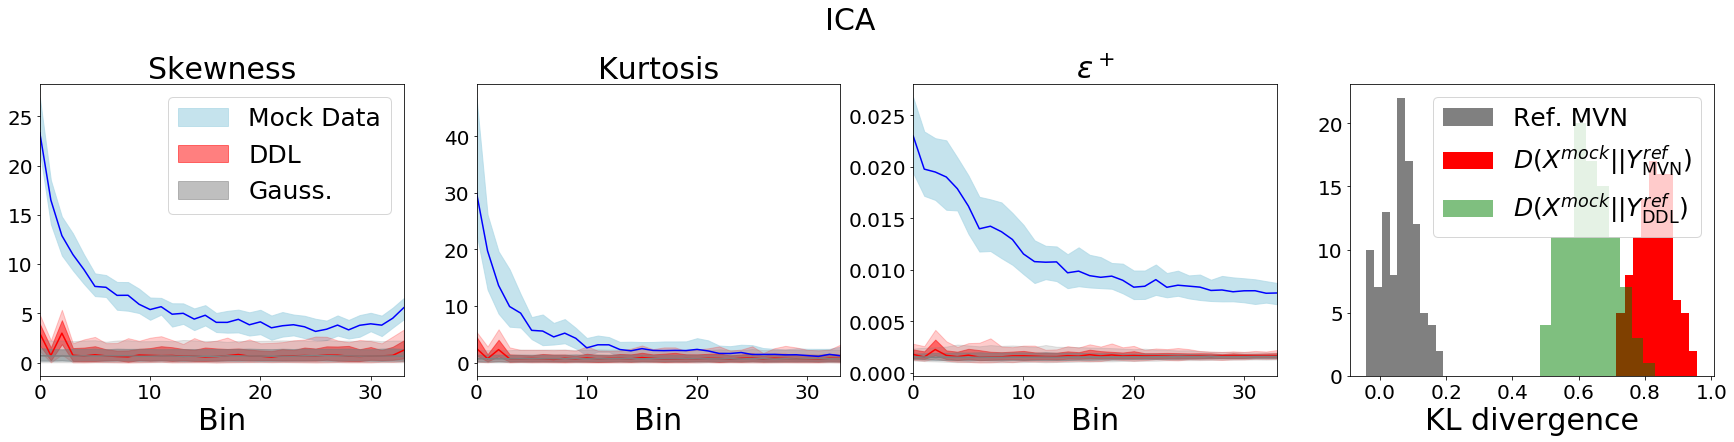

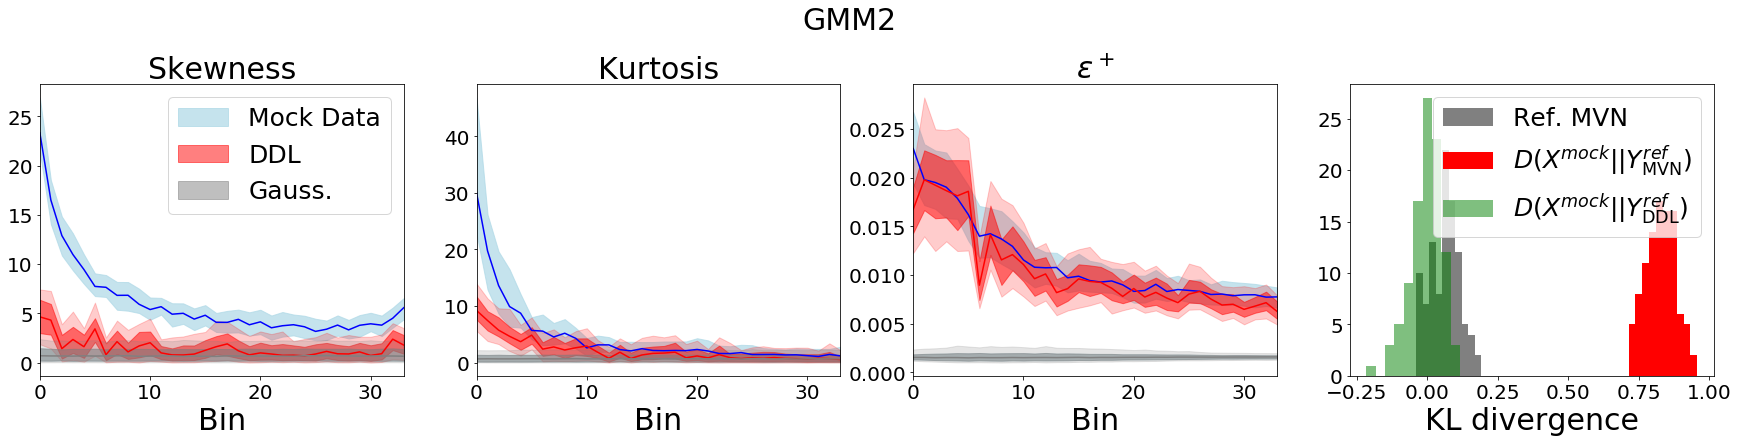

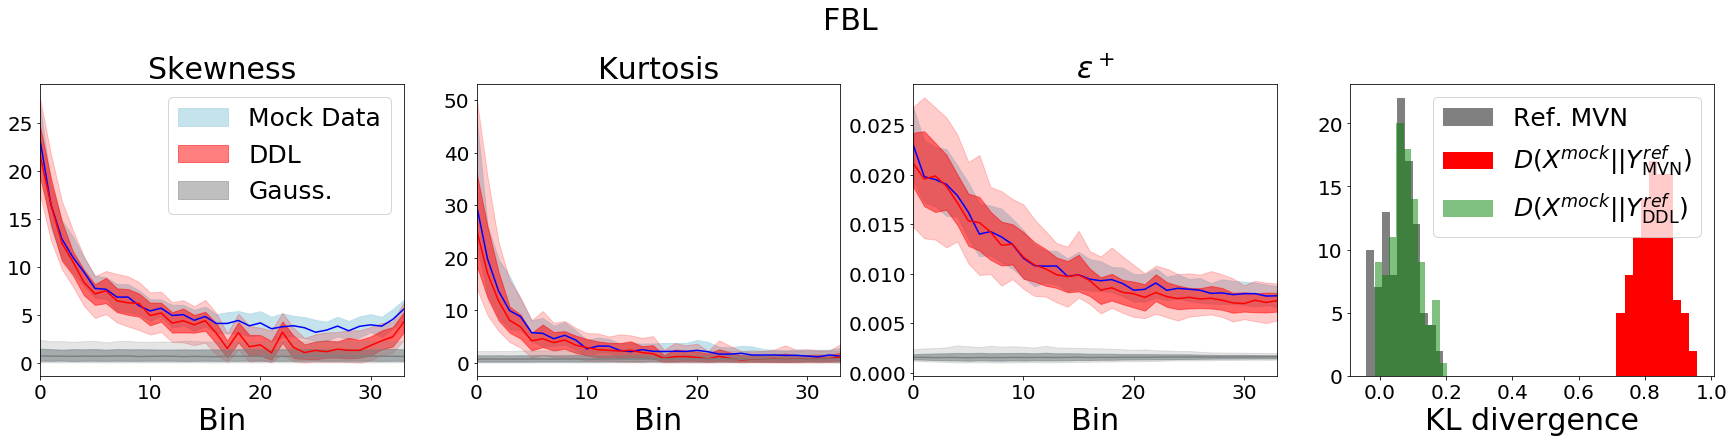

In [139]:
fig_dataintervals_lmax('WL', 'ICA', kl_data_ica, kl_ref_mvn,lmax=5000.0)
fig_dataintervals_lmax('WL', 'GMM2', kl_data_gmm, kl_ref_mvn,lmax=5000.0)
label = 'WLdata_lr0.001_bs500_blocks1_dim64_concatsquash_t0.5_afelu_lmax5000.0'
fig_dataintervals_lmax('WL', 'NF', kl_data_nf, kl_ref_mvn, NF_label=label, epoch=e)

#### Figure 5

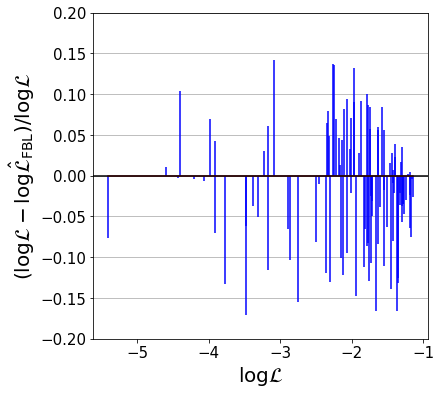

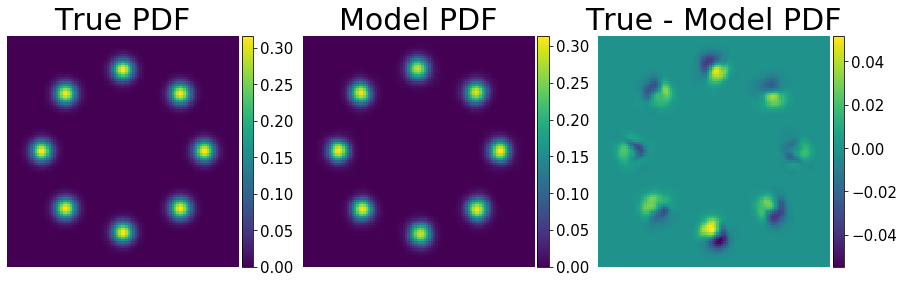

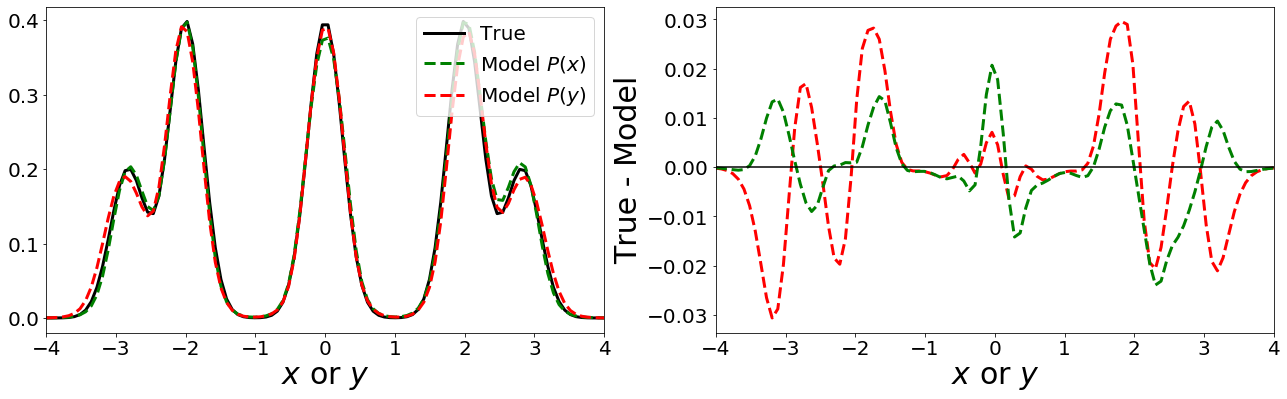

In [82]:
rootdir = '/n/holyscratch01/dvorkin_lab/adiazrivero/ffjord/'
diri = rootdir + 'experiment2_arrays/'
itr = 10000

true_loglike = np.load(diri + 'iter%s_truetrainloglike.npy' % (itr)) 
true_test_loglike = np.load(diri + 'truetestloglike.npy')
logpx = np.load(diri + 'iter%s_predtrainloglike.npy' % (itr))                   
test_loglike = np.load(diri + 'iter%s_predtestloglike.npy' % (itr)) 
final_pdf_dicti = np.load(diri + 'iter%s_predpdf.npz' % (itr))
true_pdf_dicti = np.load(diri + 'truepdf.npz')

mini = final_pdf_dicti['mini']
maxi = final_pdf_dicti['maxi']
final_pdf = final_pdf_dicti['arr']
side = np.linspace(mini,maxi,final_pdf_dicti['npts'])
true_pdf = true_pdf_dicti['arr']

true_prob = simps(simps(true_pdf,side), side)
final_prob = simps(simps(final_pdf,side), side)
diff = true_prob - final_prob

renorm = False

if renorm == True:
    print('renormalizing both')
    norm1 = 1/final_prob
    norm2 = 1/true_prob

    final_pdf = final_pdf * norm1
    true_pdf = true_pdf * norm2

    true_loglike = true_loglike + np.log(norm2)
    true_test_loglike = true_test_loglike + np.log(norm2)
    test_loglike = test_loglike + np.log(norm2)
    logpx = logpx + np.log(norm1)

fig,ax = plt.subplots(1,figsize=(6,6))

ax.set_ylabel('$(\log\mathcal{L} - \log\hat{\mathcal{L}}_{\\rm FBL})/\log\mathcal{L}$',fontsize=20)
ax.set_xlabel('$\log\mathcal{L}$',fontsize=20)
ax.grid(which='major',axis='y')
ax.set_ylim(-0.2,0.2)
ax.stem(true_test_loglike,(true_test_loglike-test_loglike.reshape(-1))/true_test_loglike, 'blue',markerfmt=' ',use_line_collection=True)
ax.axhline(0,color='k')

plt.show()

fig,ax = plt.subplots(1,3,figsize=(15,5))

im = ax[1].imshow(final_pdf,origin='lower')
ax[1].set_axis_off()
ax[1].set_title('Model PDF',fontsize=30)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
c = fig.colorbar(im, cax=cax, orientation='vertical')
c.ax.tick_params(labelsize=15)

im = ax[0].imshow(true_pdf,origin='lower')
ax[0].set_axis_off()
ax[0].set_title('True PDF',fontsize=30)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[2].imshow(true_pdf - final_pdf,origin='lower')
ax[2].set_axis_off()
ax[2].set_title('True - Model PDF',fontsize=30)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

fig,ax = plt.subplots(1,2,figsize=(22,6))

ax[0].set_xlabel('$x$ or $y$',fontsize=30)
ax[0].plot(side,simps(true_pdf,side),label='True',color='k',linewidth=3)
ax[0].plot(side,simps(final_pdf.T,side),label='Model $P(x)$',color='green',linestyle='dashed',linewidth=3)
ax[0].plot(side,simps(final_pdf,side),label='Model $P(y)$',color='red',linestyle='dashed',linewidth=3)
ax[0].legend(fontsize=20,loc='upper right')
ax[0].set_xlim(mini,maxi)
ax[0].tick_params(labelsize=20)

ax[1].set_xlabel('$x$ or $y$',fontsize=30)
ax[1].set_ylabel('True - Model',fontsize=30)
ax[1].plot(side,simps(true_pdf,side)-simps(final_pdf,side),label='$P(y)$',color='red',linewidth=3,linestyle='dashed',)
ax[1].plot(side,simps(true_pdf.T,side)-simps(final_pdf.T,side),label='$P(x)$',color='green',linewidth=3,linestyle='dashed',)
ax[1].axhline(0,color='k')    
ax[1].set_xlim(mini,maxi)
ax[1].tick_params(labelsize=20)

plt.show()

#### Figures 6 and 7

In [75]:
sys.path.append("/n/home04/adiazrivero/likelihood_nongaussianity/ffjord/")
import lib.utils as utils
import lib.layers.odefunc as odefunc
from my_toy_data import GMM_data,Gauss8,MVNCurve
from functions import *
from train_misc import *

def get_transforms(model):

    def sample_fn(z, logpz=None):
        if logpz is not None:
            return model(z, logpz, reverse=True)
        else:
            return model(z, reverse=True)

    def density_fn(x, logpx=None):
        if logpx is not None:
            return model(x, logpx, reverse=False)
        else:
            return model(x, reverse=False)

    return sample_fn, density_fn

def flow_samples(num_samples, dim, prior_sample, transform):
    
    memory = num_samples
    z = prior_sample(num_samples, dim).type(torch.float32).to(device)
    zk = []
    inds = torch.arange(0, z.shape[0]).to(torch.int64)

    for ii in torch.split(inds, int(memory**2)):
        zk.append(transform(z[ii]))
    zk = torch.cat(zk, 0).cpu().detach().numpy()

    return zk 

def flow_loglike(x, model):
    
    if type(x) == torch.Tensor:
        x = x.to(device)
    else:
        x = torch.from_numpy(x).type(torch.float32).to(device)
        
    zero = torch.zeros(x.shape[0], 1).to(x)
    z, delta_logp = model(x, zero)
    logpz = standard_normal_logprob(z).sum(1, keepdim=True)
    logpx = logpz - delta_logp
    
    return logpx

def make_cov(batch_size,lengthscale,add_diagonal=False):
    
    cov = np.zeros((batch_size,batch_size))
    
    for i in range(batch_size):
        for j in range(batch_size):
            cov[i,j] = kern(i,j,lengthscale)
            if add_diagonal:
                if i == j:
                    cov[i,j] += 1 #make matrix non-singular
    return cov

def kern(a,b,l):
    return np.exp(-(a-b)**2/(l**2))

load_dir, itr, add_diag = 'experimentnewcov_MVNCurve_bs500_blocks3_dim256', 13000, True
checkpoint = torch.load('/n/holyscratch01/dvorkin_lab/adiazrivero/ffjord/' + load_dir + '_arrays/iter%s_checkpt.pth' % itr) 

args = checkpoint['args']
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
    
dim = 30
thetas = np.linspace(0, 360, 30)
mu = 10 * np.sin(thetas)
cov = make_cov(30, lengthscale=4, add_diagonal=add_diag)

print('COV DETERMINANT:', np.linalg.det(cov))

true_mean = mu 
true_cov = cov

#generate MVN samples
sample_size = 2000    
toy = MVNCurve(mean=true_mean,cov=true_cov)
data = toy.sample(sample_size)

true_corr = np.zeros(np.shape(true_cov))
for i in range(np.shape(true_cov)[0]):
    for j in range(np.shape(true_cov)[1]):
        true_corr[i,j] = true_cov[i,j]/np.sqrt(true_cov[i,i] * true_cov[j,j])

#re-initialize model
regularization_fns, regularization_coeffs = create_regularization_fns(args)
model = build_model_tabular(args, dim, regularization_fns).to(device)
if args.spectral_norm: 
    add_spectral_norm(model)
set_cnf_options(args, model)
model.load_state_dict(checkpoint['state_dict'])

#generate NF samples
sample_fn, density_fn = get_transforms(model)
nf_samples = flow_samples(sample_size, dim, prior_sample=torch.randn, transform=sample_fn)

data_avg = np.mean(data,axis=0)
data_low = np.percentile(data,16,axis=0)
data_high = np.percentile(data,84,axis=0)
data_low2 = np.percentile(data,2.5,axis=0)
data_high2 = np.percentile(data,97.5,axis=0)
data_cov = np.cov(data.T)
data_corr = np.corrcoef(data.T)

nf_avg = np.mean(nf_samples,axis=0)
nf_low = np.percentile(nf_samples,16,axis=0)
nf_high = np.percentile(nf_samples,84,axis=0)
nf_low2 = np.percentile(nf_samples,2.5,axis=0)
nf_high2 = np.percentile(nf_samples,97.5,axis=0)
nf_cov = np.cov(nf_samples.T)
nf_corr = np.corrcoef(nf_samples.T)

samps_alltrue = mvn.rvs(true_mean, true_cov, sample_size)
samps_nfcov = mvn.rvs(true_mean, nf_cov, sample_size)
samps_nfmean = mvn.rvs(nf_avg, true_cov, sample_size)
samps_allnf = mvn.rvs(nf_avg, nf_cov, sample_size)


######################## LIKELIHOODS ######################## 

data_loglike_nfmodel = flow_loglike(data, model).cpu().detach().numpy()
nfsamples_loglike_nfmodel = flow_loglike(nf_samples,model).cpu().detach().numpy()

data_loglike_alltrue = mvn.logpdf(data, true_mean, true_cov, allow_singular=True)

data_loglike_mvnconv = mvn.logpdf(data, true_mean, data_cov, allow_singular=True)
data_loglike_mvnmean = mvn.logpdf(data, data_avg, true_cov, allow_singular=True)
data_loglike_allmvn = mvn.logpdf(data, data_avg, data_cov, allow_singular=True)

data_loglike_nfconv = mvn.logpdf(data, true_mean, nf_cov, allow_singular=True)
data_loglike_nfmean = mvn.logpdf(data, nf_avg, true_cov, allow_singular=True)
data_loglike_allnf = mvn.logpdf(data, nf_avg, nf_cov, allow_singular=True)

nf_loglike_alltrue = mvn.logpdf(nf_samples, true_mean, true_cov, allow_singular=True)

nf_loglike_mvnconv = mvn.logpdf(nf_samples, true_mean, data_cov, allow_singular=True)
nf_loglike_mvnmean = mvn.logpdf(nf_samples, data_avg, true_cov, allow_singular=True)
nf_loglike_allmvn = mvn.logpdf(nf_samples, data_avg, data_cov, allow_singular=True)

nf_loglike_nfconv = mvn.logpdf(nf_samples, true_mean, nf_cov, allow_singular=True)
nf_loglike_nfmean = mvn.logpdf(nf_samples, nf_avg, true_cov, allow_singular=True)
nf_loglike_allnf = mvn.logpdf(nf_samples, nf_avg, nf_cov, allow_singular=True)

######################## ######################## ######################## ######################## 

COV DETERMINANT: 173503.8793204984


/n/home04/adiazrivero/likelihood_nongaussianity/ffjord/lib/layers/odefunc.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).type_as(y)


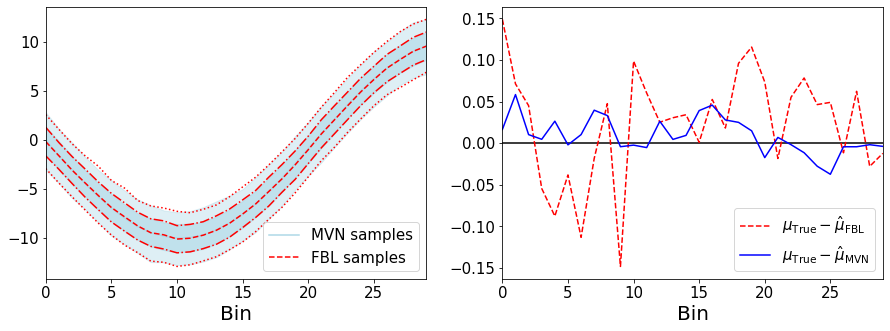

In [76]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(range(dim), data_avg, color='lightblue',label='MVN samples')
ax[0].fill_between(range(dim), data_low, data_high,alpha=0.6,color='lightblue')
ax[0].fill_between(range(dim), data_low2, data_high2,alpha=0.4,color='lightblue')
ax[0].plot(range(dim),nf_avg,color='red',linestyle='dashed',label='FBL samples')
ax[0].plot(range(dim),nf_low,color='red',linestyle='-.')
ax[0].plot(range(dim),nf_high,color='red',linestyle='-.')
ax[0].plot(range(dim),nf_low2,color='red',linestyle='dotted')
ax[0].plot(range(dim),nf_high2,color='red',linestyle='dotted')
ax[0].set_xlim(0,dim-1)
ax[0].set_xlabel('Bin',fontsize=20)
ax[0].legend(fontsize=15,loc='lower right')

res_nf = (true_mean - nf_avg)
res_mvn =  (true_mean - data_avg)

ax[1].axhline(0,color='k')
ax[1].plot(range(dim),res_nf, label='$\mu_{\\rm True} - \hat{\mu}_{\\rm FBL}$',color='red',linestyle='dashed')
ax[1].plot(range(dim),res_mvn, label='$\mu_{\\rm True} - \hat{\mu}_{\\rm MVN}$',color='blue')
ax[1].legend(loc='lower right',fontsize=15)
ax[1].set_xlim(0,dim-1)
ax[1].set_xlabel('Bin',fontsize=20)

plt.show()

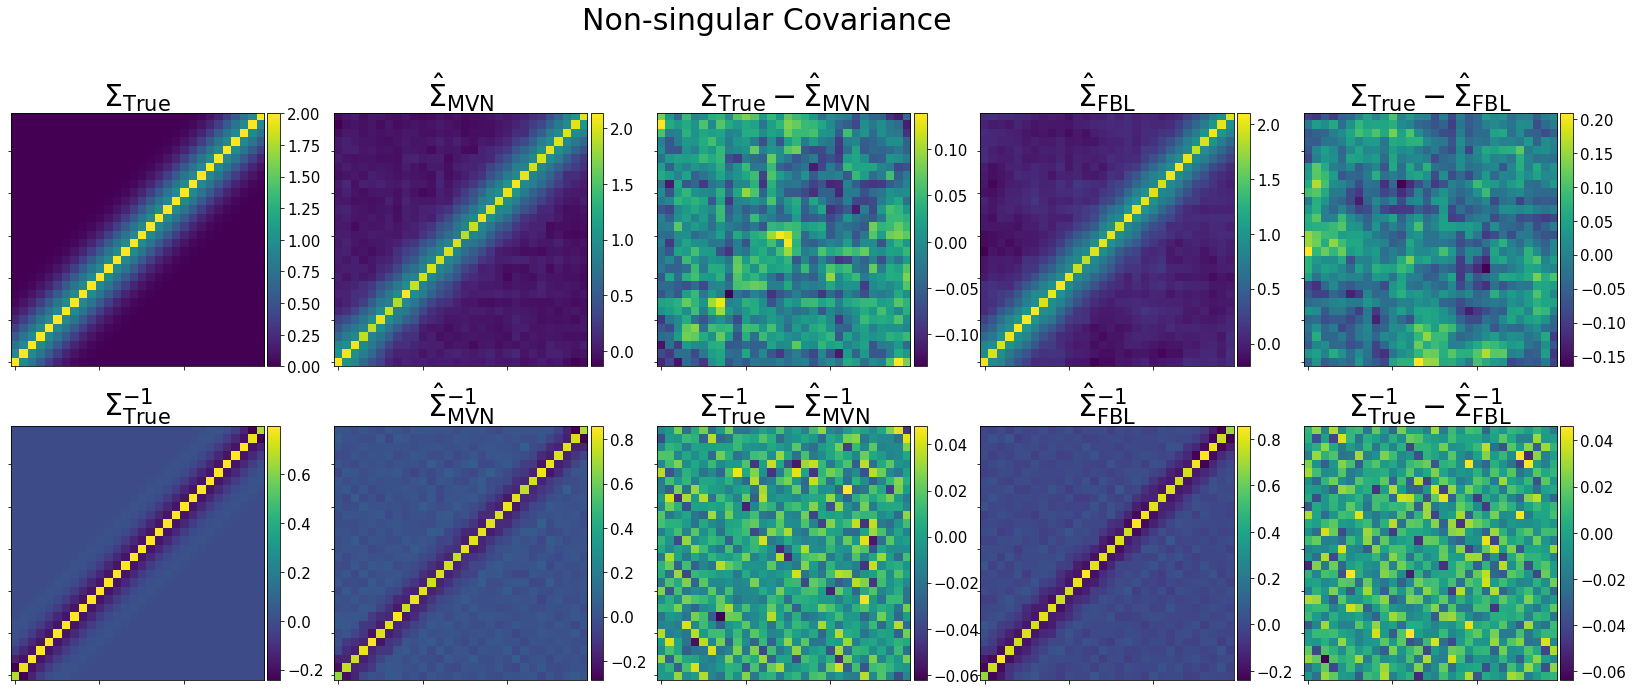

In [78]:
fig,ax = plt.subplots(2,5,figsize=(28,11))
fig.suptitle('Non-singular Covariance',fontsize=30)

for c in range(2):
    for c2 in range(5):
        ax[c,c2].set_xticklabels([])
        ax[c,c2].set_yticklabels([])
        
ax[0,0].set_title('$\Sigma_{\\rm True}$',fontsize=30)
im = ax[0,0].imshow(true_cov,origin='lower')
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im,cax=cax)    

ax[0,1].set_title('$\hat{\Sigma}_{\\rm MVN}$',fontsize=30)
im = ax[0,1].imshow(data_cov,origin='lower')
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im,cax=cax)

ax[0,2].set_title('$\Sigma_{\\rm True} - \hat{\Sigma}_{\\rm MVN}$',fontsize=30)
im = ax[0,2].imshow(true_cov - data_cov,origin='lower')#,vmin=-0.05,vmax=0.05)
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im,cax=cax)

ax[0,3].set_title('$\hat{\Sigma}_{\\rm FBL}$',fontsize=30)
im = ax[0,3].imshow(nf_cov,origin='lower')
divider = make_axes_locatable(ax[0,3])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im,cax=cax)

ax[0,4].set_title('$\Sigma_{\\rm True} - \hat{\Sigma}_{\\rm FBL}$',fontsize=30)
im = ax[0,4].imshow(true_cov - nf_cov,origin='lower')#,vmin=-0.05,vmax=0.05)
divider = make_axes_locatable(ax[0,4])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im,cax=cax)


ax[1,0].set_title('$\Sigma^{-1}_{\\rm True}$',fontsize=30)
im = ax[1,0].imshow(np.linalg.inv(true_cov),origin='lower')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im,cax=cax)    

ax[1,1].set_title('$\hat{\Sigma}^{-1}_{\\rm MVN}$',fontsize=30)
im = ax[1,1].imshow(np.linalg.inv(data_cov),origin='lower')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im,cax=cax)

ax[1,2].set_title('$\Sigma^{-1}_{\\rm True} - \hat{\Sigma}^{-1}_{\\rm MVN}$',fontsize=30)
im = ax[1,2].imshow(np.linalg.inv(true_cov) - np.linalg.inv(data_cov),origin='lower')#,vmin=-0.05,vmax=0.05)
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im,cax=cax)

ax[1,3].set_title('$\hat{\Sigma}^{-1}_{\\rm FBL}$',fontsize=30)
im = ax[1,3].imshow(np.linalg.inv(nf_cov),origin='lower')
divider = make_axes_locatable(ax[1,3])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im,cax=cax)

ax[1,4].set_title('$\Sigma^{-1}_{\\rm True} - \hat{\Sigma}^{-1}_{\\rm FBL}$',fontsize=30)
im = ax[1,4].imshow(np.linalg.inv(true_cov) - np.linalg.inv(nf_cov),origin='lower')#,vmin=-0.05,vmax=0.05)
divider = make_axes_locatable(ax[1,4])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im,cax=cax)

plt.subplots_adjust(top=0.85)
plt.show()


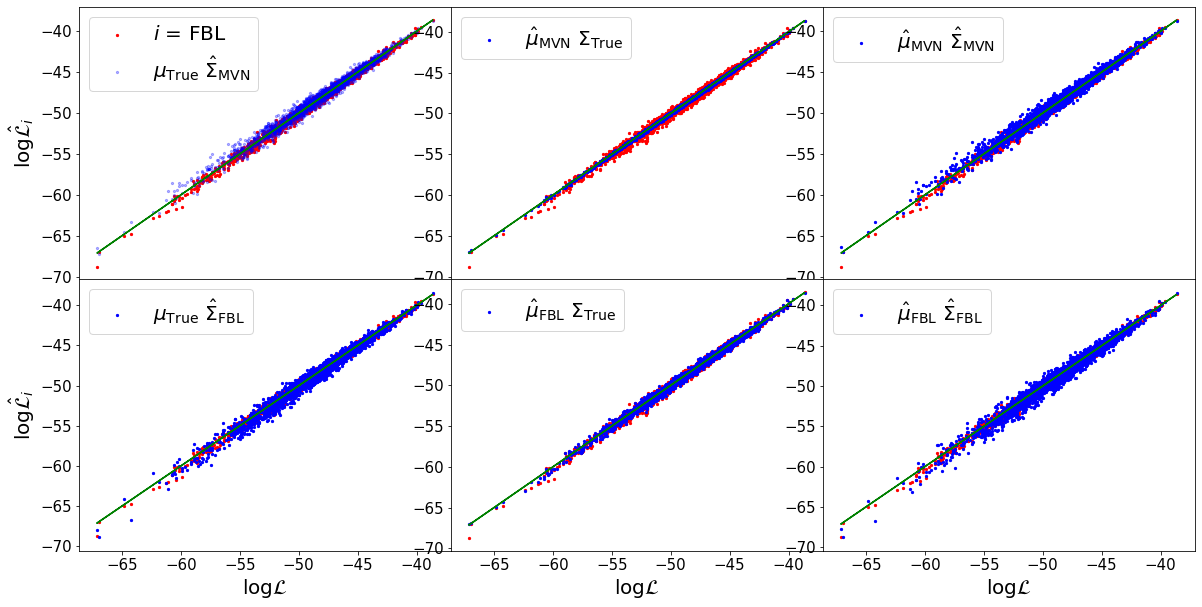

In [79]:
fig,ax = plt.subplots(2,3,figsize=(20,10),sharex=True)#,sharey=True)
#fig.suptitle('DATA',fontsize=20)

ax[0,0].scatter(data_loglike_alltrue,data_loglike_nfmodel,color='red',s=5,label='$i$ = FBL')
ax[0,0].plot(data_loglike_alltrue,data_loglike_alltrue,color='g')#,label='true mean true cov')
ax[0,0].scatter(data_loglike_alltrue,data_loglike_mvnconv,s=5,color='blue',label='$\\mu_{\\rm True}$ $\hat{\Sigma}_{\\rm MVN}$',alpha=0.3)
ax[0,0].set_ylabel('$\log\hat{\mathcal{L}}_i$',fontsize=20)
ax[0,0].legend(fontsize=20,loc='upper left')

#ax[0,1].set_title('MVN samp. mean true cov')
ax[0,1].scatter(data_loglike_alltrue,data_loglike_nfmodel,color='red',s=5)
ax[0,1].plot(data_loglike_alltrue,data_loglike_alltrue,color='g')
ax[0,1].scatter(data_loglike_alltrue,data_loglike_mvnmean,s=5,color='blue',label='$\hat{\mu}_{\\rm MVN}$ $\Sigma_{\\rm True}$')
ax[0,1].legend(fontsize=20)

#ax[0,2].set_title('MVN samp. mean MVN samp. cov')
ax[0,2].scatter(data_loglike_alltrue,data_loglike_nfmodel,color='red',s=5)
ax[0,2].plot(data_loglike_alltrue,data_loglike_alltrue,color='g')
ax[0,2].scatter(data_loglike_alltrue,data_loglike_allmvn,s=5,color='blue',label='$\hat{\mu}_{\\rm MVN}$ $\hat{\Sigma}_{\\rm MVN}$')
ax[0,2].legend(fontsize=20)

#ax[1,0].set_title('true mean NF samp. cov')
ax[1,0].scatter(data_loglike_alltrue,data_loglike_nfmodel,color='red',s=5)
ax[1,0].plot(data_loglike_alltrue,data_loglike_alltrue,color='g')
ax[1,0].scatter(data_loglike_alltrue,data_loglike_nfconv,s=5,color='blue',label='$\\mu_{\\rm True}$ $\hat{\Sigma}_{\\rm FBL}$')
ax[1,0].set_xlabel('$\log\mathcal{L}$',fontsize=20)
ax[1,0].set_ylabel('$\log\hat{\mathcal{L}}_i$',fontsize=20)
ax[1,0].legend(fontsize=20)

#ax[1,1].set_title('NF samp. mean true cov')
ax[1,1].scatter(data_loglike_alltrue,data_loglike_nfmodel,color='red',s=5)
ax[1,1].plot(data_loglike_alltrue,data_loglike_alltrue,color='g')
ax[1,1].scatter(data_loglike_alltrue,data_loglike_nfmean,s=5,color='blue',label='$\hat{\mu}_{\\rm FBL}$ $\Sigma_{\\rm True}$')
ax[1,1].set_xlabel('$\log\mathcal{L}$',fontsize=20)
ax[1,1].legend(fontsize=20,loc='upper left')

#ax[1,2].set_title('NF samp. mean NF samp. cov')
ax[1,2].scatter(data_loglike_alltrue,data_loglike_nfmodel,color='red',s=5)
ax[1,2].plot(data_loglike_alltrue,data_loglike_alltrue,color='g')
ax[1,2].scatter(data_loglike_alltrue,data_loglike_allnf,s=5,color='blue',label='$\hat{\mu}_{\\rm FBL}$ $\hat{\Sigma}_{\\rm FBL}$')
ax[1,2].set_xlabel('$\log\mathcal{L}$',fontsize=20)
ax[1,2].legend(fontsize=20)

plt.subplots_adjust(wspace=0,hspace=0)
plt.show()